# Empirical study on the relationship between the US university tuition fee and the university location and the value of the tuition

### Abstract

    Recent years, more and more students are arguing about the expensive tuition fee they must afford. More and more people are concerned about when they will make the money back after they graduate. 
	In this project, I will first examine whether tuition and potential salary are different for undergraduate in different states in the US. Then, I will be looking at whether post education is beneficial in finding jobs or not. 


### Packages import

In [65]:
pip install pmdarima

     |████████████████████████████████| 1.4 MB 7.4 MB/s eta 0:00:01�████▌                    | 512 kB 7.4 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [54]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import patsy
from sklearn import (
    linear_model, metrics, neural_network, pipeline, model_selection,ensemble
)
from sklearn.linear_model import LogisticRegression
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

import seaborn as sns
from scipy.stats import pearsonr

### Data Import

In [2]:
historical_tuitition = pd.read_csv("historical_tuition.csv")
salary_potential = pd.read_csv("salary_potential.csv")
tuition_cost =  pd.read_csv("tuition_cost.csv")
unemployment_rate =  pd.read_csv("Unemployment_rate.csv")
gdp =  pd.read_csv("export.csv")


In [3]:
gdp_cleaned = gdp.iloc[::-1]
gdp_cleaned = gdp_cleaned.iloc[40:]
gdp_cleaned = gdp_cleaned.rename({"label":"year"},axis='columns')

In [4]:
gdp_cleaned['year'] = pd.to_datetime(gdp_cleaned['year'],format='%Y')
gdp_cleaned=gdp_cleaned.set_index("year")
gdp_cleaned.head()

,GDP Per Capita
year,
2000-01-01,36334.908777
2001-01-01,37133.242809
2002-01-01,38023.161114
2003-01-01,39496.485875
2004-01-01,41712.801068


### Data Reshaping

There are many columns in the historical tuition fee dataframe, only the tuition cost is needed here. Therefore, the mean of tuition cost 3 types of insistution are displayed here

In [5]:
his_t_inf = historical_tuitition.groupby("year").mean()
his_t_inf = his_t_inf.reset_index()
i = 0
size = len(his_t_inf["year"])
while i < size:
    his_t_inf["year"][i] = his_t_inf["year"][i].split("-")[0]
    i += 1
his_t_inf

his_t_inf['year']= pd.to_datetime(his_t_inf['year'])
his_t_inf = his_t_inf.iloc[2:]  #to cut the first 2 rows to match the year
his_t_inf.head()

/tmp/ipykernel_842/1717823234.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  his_t_inf["year"][i] = his_t_inf["year"][i].split("-")[0]


,year,tuition_cost
2,2000-01-01,14371.444444
3,2001-01-01,14987.555556
4,2002-01-01,15741.166667
5,2003-01-01,16684.333333
6,2004-01-01,17300.722222


Potential Salary by states in both early career pay and mid career pay for undergraduate

In [6]:
salary_potential = salary_potential.rename({"state_name" : "state"} ,axis='columns')
sal_pot_inf = salary_potential[["state","early_career_pay","mid_career_pay"]].groupby("state").mean()
sal_pot_inf.head()

,early_career_pay,mid_career_pay
state,,
Alabama,44992.000000,81592.000000
Alaska,55133.333333,97600.000000
Arizona,50228.571429,90642.857143
Arkansas,44110.526316,79242.105263
California,67232.000000,123976.000000


Tuition cost by states

In [7]:
tuit_cost_inf = tuition_cost.groupby("state").mean()
tuit_cost_inf.head()

,room_and_board,in_state_tuition,in_state_total,out_of_state_tuition,out_of_state_total
state,,,,,
Alabama,7768.000000,10460.129630,15494.944444,14848.814815,19883.629630
Alaska,9388.333333,9549.500000,18937.833333,16991.500000,26379.833333
Arizona,8705.666667,8226.352941,12835.235294,13875.647059,18484.529412
Arkansas,7731.125000,9454.326087,13487.956522,12132.260870,16165.891304
California,12340.454545,14721.625984,20065.917323,20166.937008,25511.228346


Unemployment rate since 2000. The original data set contains larger period data, however, to match with the rest the data set, the Data is limited

In [8]:
unemployment_rate = unemployment_rate.rename({"Date" : "year"},axis='columns')
unemployment_rate['year'] = pd.to_datetime(unemployment_rate['year'])
une_rate_inf = unemployment_rate.groupby(pd.Grouper(key='year', freq='Y')).mean().dropna()
une_rate_inf = une_rate_inf.iloc[10:27]
une_rate_inf = une_rate_inf.reset_index()
une_rate_inf['year'] = une_rate_inf['year'].astype(str)

i = 0
size = len(une_rate_inf["year"])
while i < size:
    une_rate_inf["year"][i] = une_rate_inf["year"][i].split("-")[0]
    i += 1
une_rate_inf['year'] = pd.to_datetime(une_rate_inf['year'])

une_rate_inf

/tmp/ipykernel_842/778477351.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  une_rate_inf["year"][i] = une_rate_inf["year"][i].split("-")[0]


,year,Young workers,All workers,Recent graduates,College graduates
0,2000-01-01,6.316667,3.766667,2.775000,1.766667
1,2001-01-01,7.100000,4.433333,3.733333,2.291667
2,2002-01-01,9.108333,5.575000,4.600000,3.066667
3,2003-01-01,9.550000,5.808333,4.450000,3.200000
4,2004-01-01,9.050000,5.341667,4.300000,2.900000
5,2005-01-01,8.325000,4.883333,3.975000,2.500000
6,2006-01-01,7.666667,4.491667,3.541667,2.191667
7,2007-01-01,7.933333,4.416667,3.425000,2.141667
8,2008-01-01,9.691667,5.391667,4.041667,2.583333
9,2009-01-01,14.691667,8.891667,6.566667,4.683333


### Relationship between states and tuition cost and potential salary

In [9]:
states_df = pd.merge(tuit_cost_inf,sal_pot_inf, on = "state")
states_df_reshape = states_df[["in_state_total","out_of_state_total", "early_career_pay", "mid_career_pay"]]
states_df_reshape.head()

,in_state_total,out_of_state_total,early_career_pay,mid_career_pay
state,,,,
Alabama,15494.944444,19883.629630,44992.000000,81592.000000
Alaska,18937.833333,26379.833333,55133.333333,97600.000000
Arizona,12835.235294,18484.529412,50228.571429,90642.857143
Arkansas,13487.956522,16165.891304,44110.526316,79242.105263
California,20065.917323,25511.228346,67232.000000,123976.000000


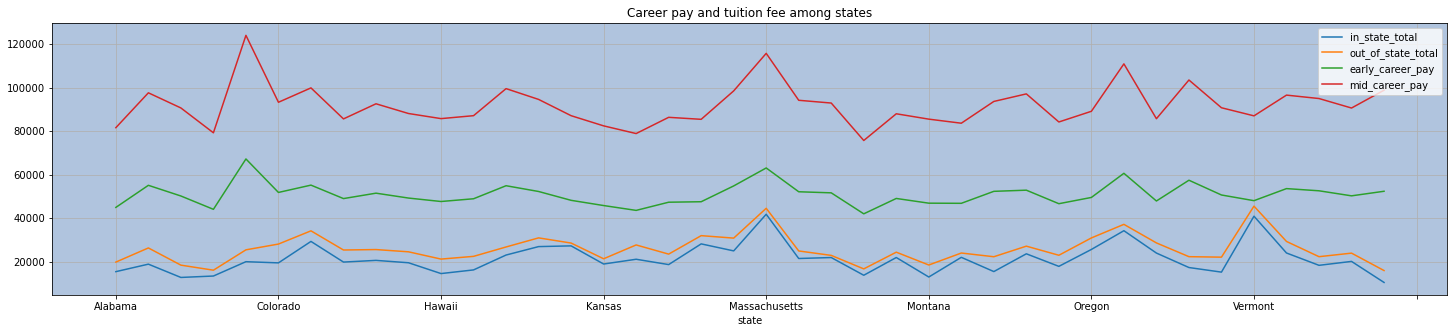

In [10]:
state_ax = states_df_reshape.plot(figsize=(25, 5), grid = 1)
fig = state_ax.get_figure()
state_ax.set_title("Career pay and tuition fee among states")
state_ax.set_facecolor('lightsteelblue')

The above graph shows the distribution of tuition fee and career pay among states. We can see some states with high tuition fee but a relative low career pay, like Vermont. Therefore, roughly from the graph, we do not see a strong correlation between tuition fee and career pay. Now, let's check the correlation and their linear regressions.

Pearsons correlation: 0.384


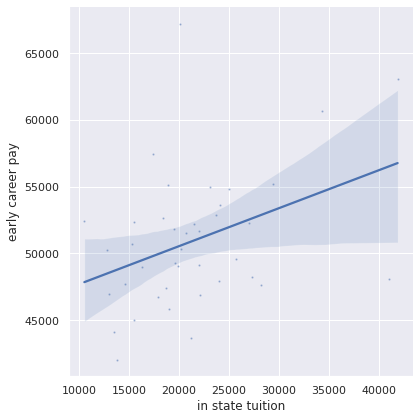

In [11]:
sns.set_theme(color_codes=True)
plt = sns.lmplot(
    data=states_df_reshape, x="in_state_total", y="early_career_pay", height=6,
    scatter_kws=dict(s=1.5, alpha=0.35)
)

plt = plt.set_axis_labels("in state tuition", "early career pay")
corr, _ = pearsonr(states_df_reshape["in_state_total"],states_df_reshape["early_career_pay"])
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.376


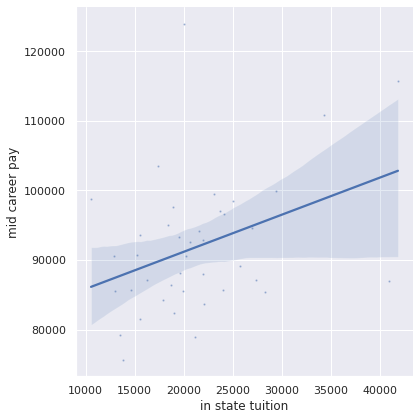

In [12]:
sns.set_theme(color_codes=True)
plt = sns.lmplot(
    data=states_df_reshape, x="in_state_total", y="mid_career_pay", height=6,
    scatter_kws=dict(s=1.5, alpha=0.35)
)

plt = plt.set_axis_labels("in state tuition", "mid career pay")
corr, _ = pearsonr(states_df_reshape["in_state_total"],states_df_reshape["mid_career_pay"])
print('Pearsons correlation: %.3f' % corr)

The above two graphs show that there is a positive trend between in state tuition and early and mid career pay. However, the Pearson correlation shows that they do not have a strong positive correlation.

#### Above all, it is really hard to say that with higher tuition, students can secure a higher payment job in the future. On the other hand, we do see some fluctuate in tuition fee and career pay varied by states. Therefore, people should go to college in the states with low tuition cost and seek job in the states with high payment. 

### Is Post Secondary Education Beneficial?


In [13]:
his_t_inf.set_index("year")

,tuition_cost
year,
2000-01-01,14371.444444
2001-01-01,14987.555556
2002-01-01,15741.166667
2003-01-01,16684.333333
2004-01-01,17300.722222
2005-01-01,17757.888889
2006-01-01,15109.000000
2007-01-01,15463.833333
2008-01-01,16240.500000


In [16]:
mid = pd.merge(his_t_inf,gdp_cleaned,on = "year")
career_df = pd.merge(une_rate_inf,mid,on = "year")

career_df.set_index("year")
career_df["Adj. GDP"] = np.log(career_df["GDP Per Capita"])
career_df

,year,Young workers,All workers,Recent graduates,College graduates,tuition_cost,GDP Per Capita,Adj. GDP
0,2000-01-01,6.316667,3.766667,2.775000,1.766667,14371.444444,36334.908777,10.500534
1,2001-01-01,7.100000,4.433333,3.733333,2.291667,14987.555556,37133.242809,10.522268
2,2002-01-01,9.108333,5.575000,4.600000,3.066667,15741.166667,38023.161114,10.545951
3,2003-01-01,9.550000,5.808333,4.450000,3.200000,16684.333333,39496.485875,10.583967
4,2004-01-01,9.050000,5.341667,4.300000,2.900000,17300.722222,41712.801068,10.638563
5,2005-01-01,8.325000,4.883333,3.975000,2.500000,17757.888889,44114.747781,10.694549
6,2006-01-01,7.666667,4.491667,3.541667,2.191667,15109.000000,46298.731444,10.742870
7,2007-01-01,7.933333,4.416667,3.425000,2.141667,15463.833333,47975.967696,10.778455
8,2008-01-01,9.691667,5.391667,4.041667,2.583333,16240.500000,48382.558449,10.786895
9,2009-01-01,14.691667,8.891667,6.566667,4.683333,23839.666667,47099.980471,10.760028


Text(0, 0.5, 'Unemployment rate(%)')

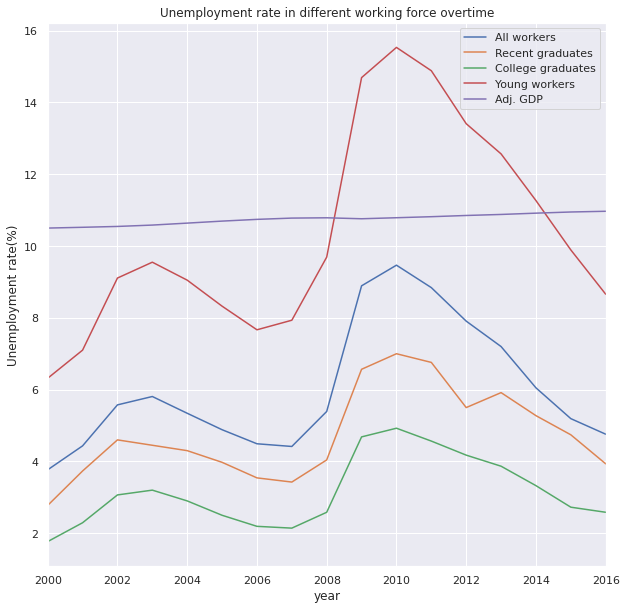

In [15]:
ax = career_df.plot(x = "year", y = ["All workers", "Recent graduates","College graduates","Young workers", "Adj. GDP"],figsize = (10,10), grid = 1)
fig = state_ax.get_figure()
ax.set_title("Unemployment rate in different working force overtime")
ax.set_ylabel("Unemployment rate(%)")

From the above graph, we see that the adjusted GDP has an overall positive trend with barely any fluctuation on slope, whereas the unemployment rate shares a similar pattern.

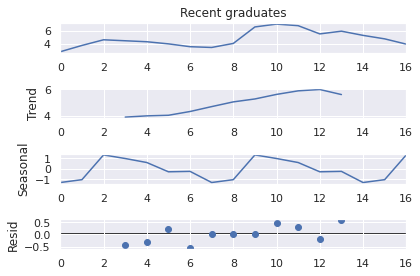

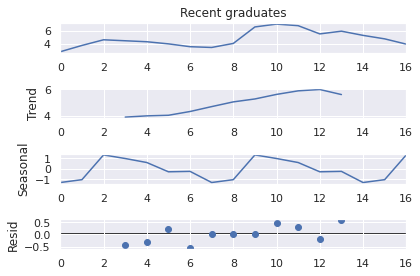

In [40]:
r_g = seasonal_decompose(career_df['Recent graduates'],model='additive', period=7)
r_g.plot()

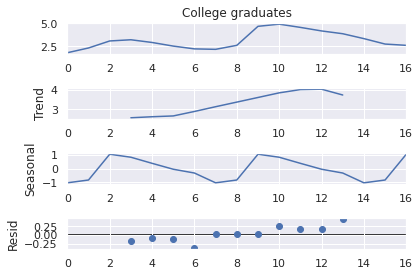

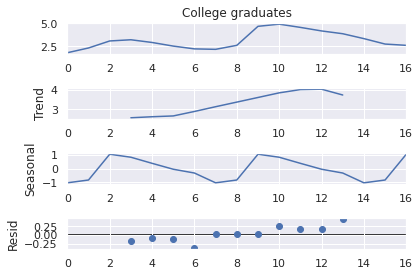

In [37]:
c_g = seasonal_decompose(career_df['College graduates'],model='additive', period=7)
c_g.plot()

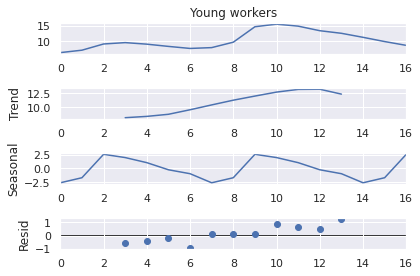

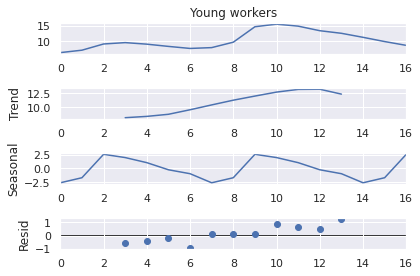

In [41]:
y_w = seasonal_decompose(career_df['Young workers'],model='additive', period=7)
y_w.plot()

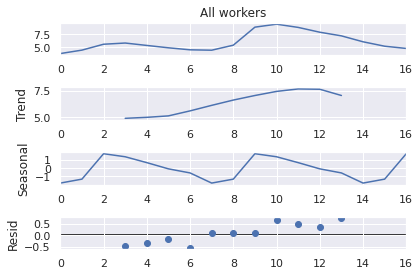

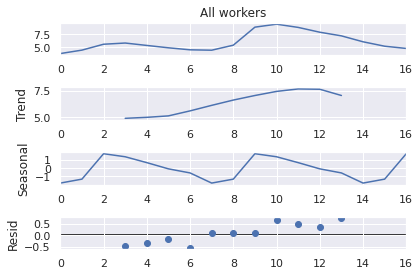

In [43]:
a_w = seasonal_decompose(career_df['All workers'],model='additive', period=7)
a_w.plot()

From the above graphs we can see that although GDP is increasing over years, the unemployment rate keeps increasing.

Pearsons correlation: 0.433


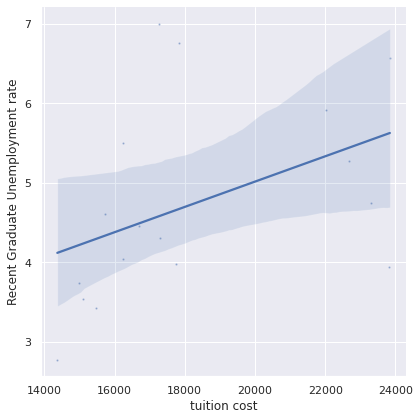

In [44]:
sns.set_theme(color_codes=True)
plt = sns.lmplot(
    data=career_df, x="tuition_cost", y="Recent graduates", height=6,
    scatter_kws=dict(s=1.5, alpha=0.35)
)

plt = plt.set_axis_labels("tuition cost", "Recent Graduate Unemployment rate")
corr, _ = pearsonr(career_df["tuition_cost"],career_df["Recent graduates"])
print('Pearsons correlation: %.3f' % corr)

Though the Pearson Correlation indicates there is no strong correlation between the tuition cost and the recent graduates unemployment rate, it is not as most of the students expected that higher tuition secures a job. Especially GDP is growing in the mean time.

In [73]:
career_df['year'] = pd.to_datetime(career_df['year'])

/tmp/ipykernel_842/225846196.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['train'] = train['Recent graduates']
/tmp/ipykernel_842/225846196.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['test'] = test['Recent graduates']


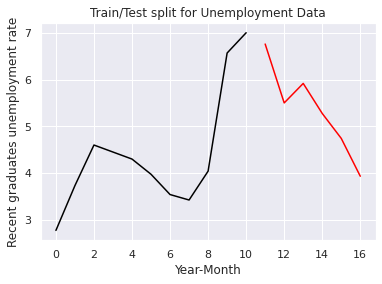

In [74]:
career_df['year'] = career_df.index
train = career_df[:11]
train['train'] = train['Recent graduates']
del train['year']
del train['Recent graduates']
train = train['train']
test = career_df[11:]
del test['year']
test['test'] = test['Recent graduates']
del test['Recent graduates']
test = test['test']
plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.title("Train/Test split for Unemployment Data")
plt.ylabel("Recent graduates unemployment rate")
plt.xlabel('Year-Month')
sns.set()
plt.show()

In [75]:
from pmdarima.arima import auto_arima
model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train)
forecast = model.predict(n_periods=len(test))
forecast = pd.DataFrame(forecast,index = test.index,columns=['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.58 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=39.736, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=36.397, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=66.641, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=32.552, Time=0.16 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=34.366, Time=0.42 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=34.225, Time=0.32 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=35.871, Time=0.36 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=37.451, Time=0.10 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit time: 2.379 seconds


<AxesSubplot:>

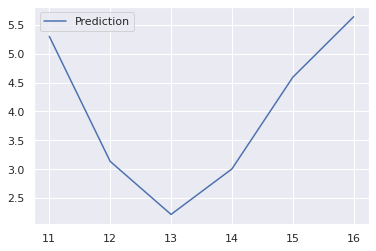

In [76]:
forecast.plot()

In [77]:
from math import sqrt
from sklearn.metrics import mean_squared_error
rms = sqrt(mean_squared_error(test,forecast))
print("RMSE: ", rms)

RMSE:  2.216787241822675


The above is the result where implemented Time Series Forecasting to find a model to predict future values

#### Above all, there is an overall positive correlation between GDP and unemployment rate, though the correlation is weak. 

### Conclusion

There are 2 takeaways I have after completing this project
- Tuition cost does not have a strong positive correlation with potential salary, which means higher tuition cost do not secure a better paying job
- Higher tuition cost does not mean a lower unemployment rate for recent graduate, instead, the unemployment rate has a weak positive correlation with tuition fee. 

### Limitation 

The number of samples is not large enough. Also there are more factors that influence recent graduate and people with a college degree to have higher unemployment rate. Future study can do further examinations.

Data are extracted from https://www.kaggle.com/dbsimpson/us-college-graduates-wages?select=Unemployment_rate.csv https://www.kaggle.com/jessemostipak/college-tuition-diversity-and-pay?select=salary_potential.csv https://datacommons.org/place/country/USA?utm_medium=explore&mprop=amount&popt=EconomicActivity&cpv=activitySource%2CGrossDomesticProduction&hl=en https://www.kaggle.com/jessemostipak/college-tuition-diversity-and-pay?select=tuition_cost.csv https://www.kaggle.com/jessemostipak/college-tuition-diversity-and-pay?select=historical_tuition.csv And time series forcasting part, I adopted my code from https://towardsdatascience.com/mastering-time-series-analysis-in-python-8219047a0351